In [1]:
import math
import torch
from torch import nn 
from d2l import torch as d2l

### tensor.repeat和torch.repeat_interleave的对比
1. 实际上tensor.repeat是对原来的tensor进行修改得到一个返回变量，不是原地修改！！！

In [2]:
a = torch.ones( 2 , 2 )
a.repeat( 1 , 1 , 1 )
print( a.shape )

torch.Size([2, 2])


* 基本用法

In [3]:
a = a.repeat( 2  , 1 ,1 )
print( a.shape  )#自动匹配轴数

torch.Size([2, 2, 2])


2. torch.repeat_interleave()的用法:一般来说第一个参数就是需要复制的tensor，然后第二个参数是要复制的参数数量。然后返回的是展平的向量

In [4]:
x = torch.tensor( [ 1 , 2 , 3 ] )
torch.repeat_interleave( x  , 2 )

tensor([1, 1, 2, 2, 3, 3])

In [5]:
def masked_softmax( X , valid_lens  ):
    """通过在最后一个轴上遮蔽元素来执行 softmax 操作，就是将数据X根据valid_lens的每一个元素为长度进行遮蔽
        请参看加性注意力中的语句有对为什么要使用遮蔽进行解释"""
    if valid_lens == None:#对最后一个维度进行softmax
        return nn.functional.softmax( X , dim= -1 )
    else:
        shape = X.shape
        if valid_lens.dim() == 1:#实际上，valid_lens每个元素对应的是一个样本的遮蔽，也就是说valid_lens必须是batch_size
            #的长度，但是如果说一个样本用一个二维张量去表示的话，就需要扩大valid_lens的长度，就是将valid_lens的每个元素*shape[ 1 ]
            #这样得到的valid_lens经过广播后能对每个样本进行遮蔽。但是请注意：因为我们只是简单将每个元素进行了复制，所以我们是对每个
            #样本的每个num_steps进行相同尺度的遮蔽。
            #比如说这个样本是[[1,1],[1,1]]，valid_lens[1]---经过repeat---->[1 ,1 ]---经过sequence_mask----得到样本为[[1,0], [1,0]]
                valid_lens = torch.repeat_interleave( valid_lens , shape[ 1 ] )
                #如果没有指定第三个参数---轴的话，那么返回的是展开的一阶张量
        else:#如果想进行对每个num_steps进行不同尺度的遮蔽，就传入二阶张量，那么请注意：传入的二阶张量必须是batch_size*num_steps的形状
            valid_lens = valid_lens.reshape( -1 )#这里主要是传入形状大于1的tensor,  就直接将其展开
        #保留最后的轴，基本的意思就是保留特征维度，这里主要是要将X进行二维化，这样可能方便对数据进行遮蔽
        X = d2l.sequence_mask( X.reshape( -1 , shape[ -1 ] ) , valid_lens , value= -1e6 )
        #将X进行reshape
        return nn.functional.softmax( X.reshape( shape ) , dim= -1 )        
    

In [6]:
x = torch.ones( 2, 1 , 2 )
y = torch.ones( 2 , 2 , 1 )#还是用到了广播机制
print( (x + y).dim() , ( x + y ).shape )

3 torch.Size([2, 2, 2])


In [7]:
masked_softmax( torch.rand(2, 2, 4) , torch.tensor( [2, 3] ) )

tensor([[[0.4897, 0.5103, 0.0000, 0.0000],
         [0.3401, 0.6599, 0.0000, 0.0000]],

        [[0.3752, 0.3940, 0.2308, 0.0000],
         [0.2726, 0.2890, 0.4384, 0.0000]]])

In [8]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3622, 0.4338, 0.2040, 0.0000]],

        [[0.4918, 0.5082, 0.0000, 0.0000],
         [0.2126, 0.3161, 0.1996, 0.2717]]])

## 加性注意力

In [9]:
class AdditiveAttention( nn.Module ):
    '''加性注意力，这里对遮蔽进行解释：我们会在qk的乘积得到的矩阵进行遮蔽，一般来说我们是对单个批次的每一行进行遮蔽，这样的意思是将单个时间步与相对的时间步的注意力分数进行遮蔽。
        我们由此得到的注意力分数与values进行相乘，可以得到相对的注意力机制'''
    def __init__( self , key_size  , query_size , num_hiddens , dropout , **kwargs ):
        super( ).__init__( **kwargs )
        self.W_k = nn.Linear( key_size , num_hiddens , bias= False )
        self.W_q = nn.Linear( query_size , num_hiddens , bias= False )
        self.W_v = nn.Linear( num_hiddens , 1 , bias= False )
        self.dropout = nn.Dropout( dropout )
    #前向传播 ---->( 查询 ，键 ， 值 ， 有效长度 )
    def forward( self  ,  queries , keys , values , valid_lens ):
        # 其中查询、键和值的形状为（批量大小、步数或词元序列长度、特征大小),
        # queries ----> ( 批量大小 ， 查询个数 , num_hiddens )
        # keys ----->( 批量大小 ，键值对个数 ， num_hiddens )
        queries , keys = self.W_q( queries ) , self.W_k( keys )
        #接下来要让实现加性注意力，我们让q与v的各个维度进行错开，实现(批量大小 ， 查询个数 ， 键值对个数 ， num_hiddens )
        #queries( 批量大小 ， 查询个数 , num_hiddens ) ----> ( 批量大小 ， 查询个数 , 1 , num_hiddens )
        #keys ( 批量大小 ，键值对个数 ， num_hiddens ) ----> ( 批量大小 ， 键值对个数 , 1 , num_hiddens )
        #之后利用广播机制进行求和
        features = queries.unsqueeze( 2 ) + keys.unsqueeze( 1 )
        features = torch.tanh( features )
        # self.w_v仅有一个输出 ，进行的操作是将
        # ( 批量大小 ， 查询个数 ， 键值对个数 ， num_hiddens ) ----> ( 批量大小 ， 查询个数 ， 键值对个数 ， 1 )
        # 之后消去最后那个维度
        scores = self.W_v( features ).squeeze( -1 )#我们就得到了注意力分数( 批量大小 ， 查询个数 ， 键值对个数 )
        #进行注意力汇聚，采用遮蔽softmax,我们应该还记得masked_softmax的基本处理方法，这里面当时写了X.size( 1 ),也
        #就是说我们是对第一轴后的元素进行遮蔽，传入的的valid_lens往往是一阶tensor，那么这样的话是会对tensor进行广播
        self.attention_weights = masked_softmax( scores , valid_lens  )
        #values的形状---> ( 批量大小 ， 键值对个数  , 值的维度 )
        #( 批量大小 ， 查询个数 ， 键值对个数 )bmm( 批量大小 ， 键值对个数 ， 值的维度 )---->
        #( 批量大小 ， 查询个数 ， 值的维度 )
        return torch.bmm( self.dropout( self.attention_weights ) , values ) 


我认为的加性注意力的公式是这样的：
$$\alpha (q,k) = {W_v}^T\tanh ({\rm{q}}{{\rm{W}}_a}{\rm{ + }}k{W_k})$$

## 我们现在进行测试：
**注意：我们谨记查询(query),键(key),值(value)的形状都是：( batch_size , 步数或者词元序列长度 , 特征大小 )**
1. query:( batch_size , 查询的个数 , 查询的维度 ) --->( 2 , 1  , 20  )
2. key:( batch_size , 键值对的个数 ， 键的维度 ) --->( 2 , 10  , 2 )
3. value:( batch_size , 键值对的个数 , 值的维度 ) --->( 2 , 10 , 4 )
4. 最后得到的结果就是( batch_size , 查询的个数 , 值的维度 ) --->( 2 , 1 , 4 )

In [10]:

queries , keys = torch.normal( 0 ,  1 , ( 2 ,1 ,20 )) , torch.ones( 2 ,10 ,2 )
values = torch.arange( 40  , dtype= torch.float32 ).reshape( 1 , 10 , 4 ).repeat( 2 , 1 ,1 )
valid_lens = torch.tensor( [ 2  ,6 ] )

attention = AdditiveAttention( key_size= 2 , query_size= 20  , num_hiddens= 10 , dropout=0.1  )
attention.eval()
attention( queries , keys , values , valid_lens )

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

## 缩放点积注意力

基本的注意力分数就是${\rm{a}}(q,k) = {q^T}k/\sqrt d $,这里就是需要保证的q的q_size和键的k_size保持相等

In [11]:
class DotProductAttention( nn.Module ):
    def __init__( self  , dropout , **kwargs ):
        super().__init__()
        self.dropout = nn.Dropout( dropout )
    # `queries` 的形状：(`batch_size`, 查询的个数, `d`)
    # `keys` 的形状：(`batch_size`, “键－值”对的个数, `d`)
    # `values` 的形状：(`batch_size`, “键－值”对的个数, 值的维度)
    # `valid_lens` 的形状: (`batch_size`,) 或者 (`batch_size`, 查询的个数)
    def forward( self , queries , keys , values , valid_lens  = None ):
        d = queries.shape[-1]
        #将keys的二轴与一轴进行转换 ---> ( `batch_size`, d , “键－值”对的个数 )
        #(`batch_size`, 查询的个数, `d`)bmm( `batch_size`, d , “键－值”对的个数 )
        #--->(`batch_size`, 查询的个数,  “键－值”对的个数 )
        scores = torch.bmm( queries , keys.transpose( 1 , 2 ) ) /math.sqrt( d )

        self.attention_weight = masked_softmax( scores , valid_lens )
        # (`batch_size`, 查询的个数,  “键－值”对的个数 )bmm(  `batch_size`, “键－值”对的个数, 值的维度 )
        # ----->(  batch_size , 查询的个数 ， 值的维度 )
        return torch.bmm( self.dropout( self.attention_weight ) , values )

In [12]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

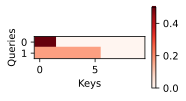

In [13]:
d2l.show_heatmaps(attention.attention_weight.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')
